# 5. XGBoost

Задание:

Внимание: два варианта работы

Построить модель для распознавания целевой переменной (отклика)

Использовать тот же набор данных, что и в первой лабораторной работе.

Для распознавания использовать XGBoost

Выбор критерия качества на Ваше усмотрение.

Обосновать выбор параметров модели.

Ожидается, что для подбора значений параметров будет использован GridSearch.
Возможен выбор других стратегий подбора.


Ответ:

В данном задании была построена модель для распознавания целевой переменной (отклика) на основе Bank Marketing Data Set. Для распознавания использовался XGBoost. Критерием качества для данной выборки выбран Recall. Для обоснования выбора параметров модели был произведен подбор данных значений параметров с помощью GridSearch.

In [292]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [293]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [294]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [295]:
df.shape

(45211, 17)

In [296]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [297]:
# Атрибут 'duration' сильно влияет на цель вывода (например, если duration=0, то y='no'),
# поэтому эти данные отбрасываем для получения реалистичной прогностической модели

df = df.loc[df['duration'] != 0]
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [298]:
df.shape

(45208, 17)

In [299]:
# Проверим сбалансированность выборки

df['y'].value_counts() # выборка не сбалансированная, тк разница в 8 раз

no     39919
yes     5289
Name: y, dtype: int64

In [300]:
df['y'].value_counts(normalize=True) # выборка не сбалансированная, тк разница в 8 раз

no     0.883007
yes    0.116993
Name: y, dtype: float64

In [301]:
# Получим новый датафрейм только со значением y=yes

df_one = df.loc[df['y'] == 'yes']
df_one.shape

(5289, 17)

In [302]:
# Получим новый датафрейм только со значением y=no и обновим индексы

df_y = df.loc[df['y'] == 'no']
df_y = df_y.reset_index(drop=True)
df_y.shape

(39919, 17)

In [303]:
# Отделим первые 10578 строк значений в датафрейме только со значением y=no

df_two = df_y.loc[:10577]
df_two.shape

(10578, 17)

In [304]:
# Создадим новый датафрейм, состоящий из двойного набора данных со значением отклика y=yes (5289*2=10578 строк)
# и набора данных со значением отклика y=no (10578 строк)

df_new = pd.concat([df_one, df_one, df_two], ignore_index=True)
df_new.shape

(21156, 17)

In [305]:
# Проверим сбалансированность выборки нового датафрейма

df_new['y'].value_counts() # выборка сбалансирована

yes    10578
no     10578
Name: y, dtype: int64

In [306]:
df_new['y'].value_counts(normalize=True) # выборка сбалансирована

yes    0.5
no     0.5
Name: y, dtype: float64

{0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid', 4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services', 8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'}


Text(0.5, 1.0, 'Распределение частотности классов в атрибуте job')

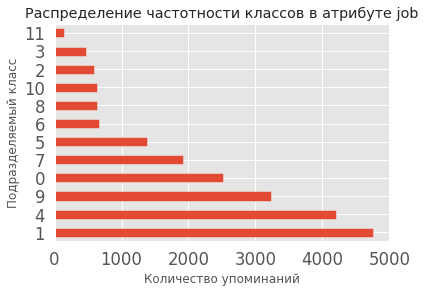

In [307]:
# Заменим категориальные признаки на числовые во всем датафрейме

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
mapped_job = pd.Series(label_encoder.fit_transform(df_new['job']))

mapped_job.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

plt.xlabel('Количество упоминаний')
plt.ylabel('Подразделяемый класс')
plt.title('Распределение частотности классов в атрибуте job')

In [308]:
categorical_columns = df_new.columns[df_new.dtypes == 'object'].union(['job'])
for column in categorical_columns:
    df_new[column] = label_encoder.fit_transform(df_new[column])
df_new.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


In [309]:
df_new.shape

(21156, 17)

In [310]:
# Преобразуем в столбцы с различными уникальными значениями, которые могут принимать категориальные столбцы исходной выборки

onehot_encoder = OneHotEncoder(sparse=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df_new[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [311]:
#  Разделяю предикоторы и отклики

X = df_new.iloc[:, :-1]  
y = df_new.iloc[:, 16]  

In [312]:
#  Разделяю на обучающую и тестовую выборку

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)  

In [313]:
#  Применяем XGBoost

#  Задаем параметры модели, обучаем

from xgboost import XGBClassifier

model = XGBClassifier(seed=42,             # зерно датчика случайных чисел
                      n_estimators=1000,   # число деревьев
                      max_depth=6,         # максимальная глубина дерева
                      learning_rate=0.1)   # скорость обучения 

model.fit(X_train, y_train)                # обучаем модель

XGBClassifier(max_depth=6, n_estimators=1000, seed=42)

In [314]:
# Посчитаем precision, recall и f1-score

from sklearn import metrics

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print (metrics.classification_report(y_train, y_pred_train))
print (metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7092
           1       1.00      1.00      1.00      7082

    accuracy                           1.00     14174
   macro avg       1.00      1.00      1.00     14174
weighted avg       1.00      1.00      1.00     14174

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3486
           1       0.98      0.98      0.98      3496

    accuracy                           0.98      6982
   macro avg       0.98      0.98      0.98      6982
weighted avg       0.98      0.98      0.98      6982



In [315]:
# Таблица сопряженности. Измеряем, насколько хороша модель

# Обучающая выборка

print(u'Таблица сопряженности для обучающей выборки')

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

Таблица сопряженности для обучающей выборки


,0,1
0,7092,0
1,0,7082


In [316]:
# Тестовая выборка

print(u'Таблица сопряженности для тестовой выборки')

conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

Таблица сопряженности для тестовой выборки


,0,1
0,3418,68
1,60,3436


In [317]:
# Получим recall на обучающей и тестовой выборках

from sklearn.metrics import recall_score

print('Recall на обучающей выборке', recall_score(y_train, y_pred_train)*100)
print('Recall на тестовой выборке', recall_score(y_test, y_pred_test)*100)

Recall на обучающей выборке 100.0
Recall на тестовой выборке 98.2837528604119


In [318]:
import seaborn as sns

sns.set(font_scale = 1.5)

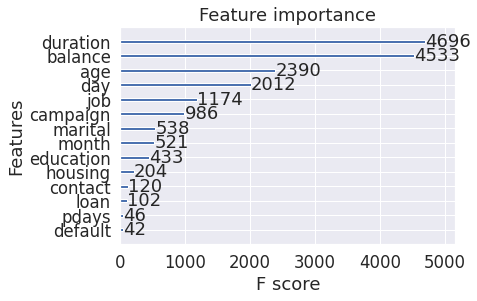

In [319]:
# Посмотрим информативность

import xgboost as xgb

xgb.plot_importance(model)

In [320]:
# Подбор внешних параметров с помощью GridSearch

from sklearn.model_selection import GridSearchCV

grid_param = {  
     'n_estimators': [100, 300, 500, 800, 1000],
     'max_depth': [2, 4, 6],
     'learning_rate': [0.05, 0.1, 0.3]
}

modelGS = GridSearchCV(cv=5, error_score='raise',                     # 5 фолдов
       estimator=XGBClassifier(base_score=0.5, seed=1234,             # указываем, что надо перебирать
       objective='binary:logistic',                         
       colsample_bylevel=1, colsample_bytree=0.8, subsample=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, 
       min_child_weight=1, missing=None, nthread=-1,
       reg_alpha=0, reg_lambda=1, 
       scale_pos_weight=1, silent=True),
        n_jobs=-1, #iid=True
       param_grid=grid_param,
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

modelGS.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(colsample_bytree=0.8, nthread=-1,
                                     seed=1234, silent=True, subsample=0.8),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [100, 300, 500, 800, 1000]},
             scoring='recall')

In [321]:
#  Посмотрим на результаты без форматирования

modelGS.cv_results_

{'mean_fit_time': array([ 0.8317997 ,  2.37242818,  3.87535191,  6.16863298,  7.58644848,
         1.24557672,  3.75387297,  6.25196896,  9.90641861, 12.66215734,
         1.79293947,  5.42532692,  9.09820437, 14.86838474, 18.32505355,
         0.78832741,  2.33656688,  3.82975554,  6.17291174,  7.70712047,
         1.29924765,  3.77012625,  6.32325654, 10.10971165, 12.81535492,
         1.85217795,  5.58541818,  9.20020671, 14.31383104, 17.90438776,
         0.79288573,  2.32206936,  3.85238409,  6.17300892,  7.66548576,
         1.27841778,  3.79686346,  6.39854078, 10.07127829, 12.37272997,
         1.84329238,  5.3553493 ,  8.55091195, 13.07313142, 15.17211742]),
 'mean_score_time': array([0.00982227, 0.02558784, 0.0422555 , 0.06713195, 0.08182082,
        0.0132072 , 0.03974638, 0.07027254, 0.11265082, 0.14575081,
        0.01693873, 0.05682993, 0.10159268, 0.17508345, 0.24184813,
        0.01074653, 0.02917094, 0.04493532, 0.06958218, 0.08543181,
        0.01542544, 0.04733119, 0

In [322]:
# Посмотрим на часть результатов, форматируя их в таблицу

results = ( 
        pd.DataFrame({
        "mean_test_score": modelGS.cv_results_["mean_test_score"],
        "mean_fit_time": modelGS.cv_results_["mean_fit_time"]})
        .join(pd.io.json.json_normalize(modelGS.cv_results_["params"]).add_prefix("param_"))
)

print(results)

    mean_test_score  mean_fit_time  param_learning_rate  param_max_depth  \
0          0.951851       0.831800                 0.05                2   
1          0.965124       2.372428                 0.05                2   
2          0.965124       3.875352                 0.05                2   
3          0.968654       6.168633                 0.05                2   
4          0.967383       7.586448                 0.05                2   
5          0.962864       1.245577                 0.05                4   
6          0.969078       3.753873                 0.05                4   
7          0.971337       6.251969                 0.05                4   
8          0.973737       9.906419                 0.05                4   
9          0.976985      12.662157                 0.05                4   
10         0.965406       1.792939                 0.05                6   
11         0.972608       5.425327                 0.05                6   
12         0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


In [323]:
#  Комбинация гиперпараметров для лучшего результата

modelGS.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}

In [324]:
#  Значение критерия качества для лучшей комбинации гиперпараметров

modelGS.best_score_

0.9798089382757397

In [325]:
#  Номер лучшей комбинации гиперпараметров в cv_results_

modelGS.best_index_

29

In [326]:
#  Лучшая модель

modelGS.best_estimator_

XGBClassifier(colsample_bytree=0.8, max_depth=6, n_estimators=1000, nthread=-1,
              seed=1234, silent=True, subsample=0.8)